In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from datasets import Dataset, load_dataset, load_metric, DatasetDict
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [2]:
# utils
def draw_image(image : torch.Tensor, mask : torch.Tensor, title1 = "", title2 = ""):
    
    image = image.cpu().detach()
    mask = mask.cpu().detach()
        
    image = image.numpy()
    mask  = mask.numpy()
    
    image = np.transpose(image, axes = [1, 2, 0])
    mask  = np.transpose(mask, axes = [1, 2, 0])
    
    
    plt.figure(figsize=(10, 5))

    # Plot the first image
    plt.subplot(1, 2, 1)
    if title1:
        plt.title(title1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the second image
    plt.subplot(1, 2, 2)
    if title2:
        plt.title(title2)
    plt.imshow(mask)
    plt.axis('off')

    plt.show()

In [3]:
from torchvision.transforms import transforms


class SegmentationDataset(Dataset):
    def __init__(self, root_path, file_names, dataset_type, transform):
        self.root_path = root_path
        self.file_names = file_names
        self.transform = transform
        self.dataset_type = dataset_type
         
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        
        img_index = self.file_names[index]
        
        img_path = os.path.join(self.root_path, self.dataset_type, "images", img_index)
        msk_path = os.path.join(self.root_path, self.dataset_type, "masks",  img_index)
        
        img = Image.open(img_path)
        msk = Image.open(msk_path)
        
        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)
        
        msk = (msk > 0.5).type(dtype = torch.float32)
        return img, msk
    
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor()            # Convert image to tensor
])

In [4]:
from glob import glob

# Train dataset
train_img_files = glob("../data/contrastprocessed/train/images/*")
train_msk_files = glob("../data/contrastprocessed/train/masks/*")

# Test dataset
test_img_files = glob("../data/contrastprocessed/test/images/*")
test_msk_files = glob("../data/contrastprocessed/test/masks/*")

# Validation dataset
val_img_files = glob("../data/contrastprocessed/val/images/*")
val_msk_files = glob("../data/contrastprocessed/val/masks/*")

train_files = []
test_files = []
validation_files = []

for file in train_img_files:
    train_files.append(file.split(sep = "\\")[1])

for file in test_img_files:
    test_files.append(file.split(sep = "\\")[1])

for file in val_img_files:
    validation_files.append(file.split(sep = "\\")[1])

In [5]:
# Dataset Object
train_dataset = SegmentationDataset(root_path = "../data/contrastprocessed/",
                                    file_names = train_files,
                                    dataset_type = "train", transform = data_transform)

test_dataset = SegmentationDataset(root_path = "../data/contrastprocessed/",
                                   file_names = test_files,
                                   dataset_type = "test", transform = data_transform)

validation_dataset = SegmentationDataset(root_path = "../data/contrastprocessed/",
                                         file_names = validation_files,
                                         dataset_type = "val", transform = data_transform)

# Dataloader object
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 4,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = 4,
                              shuffle = True)
val_dataloader = DataLoader(dataset = validation_dataset,
                            batch_size = 4,
                            shuffle = True)

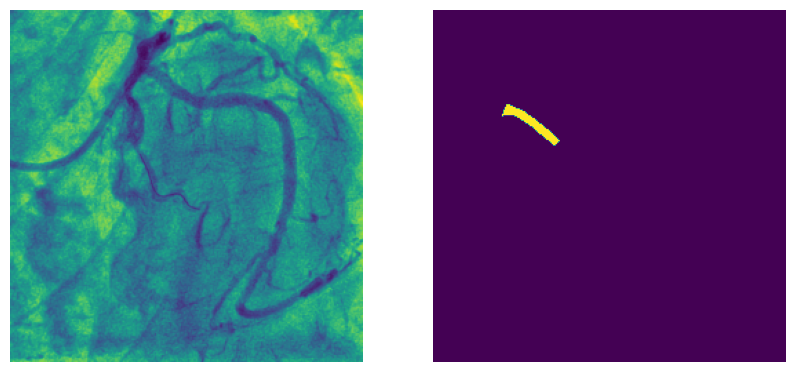

In [6]:
img, msk = next(iter(train_dataset))
draw_image(img, msk)

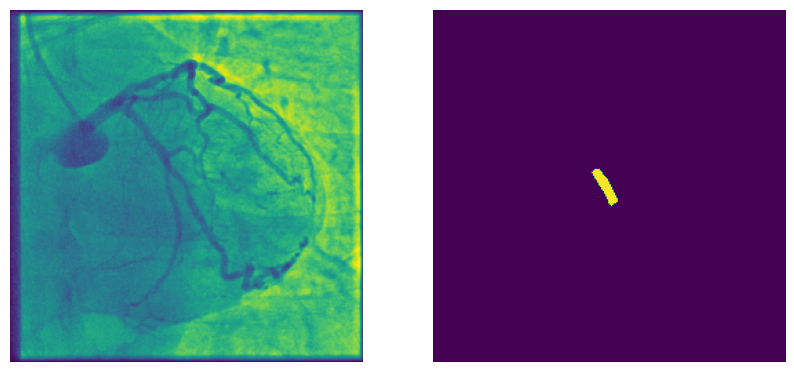

In [7]:
img, msk= next(iter(test_dataset))
draw_image(img, msk)

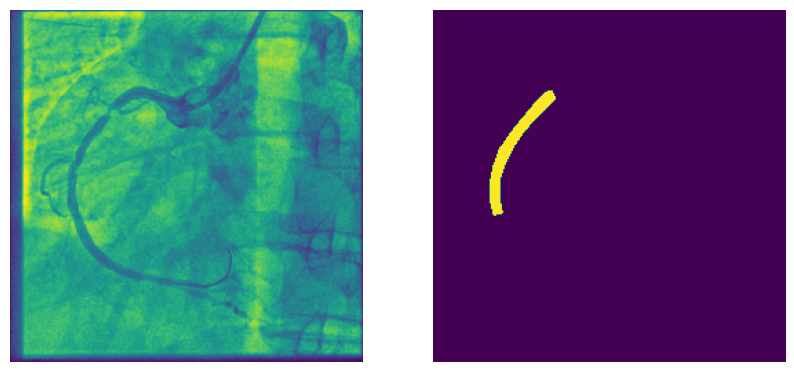

In [9]:
img, msk = next(iter(validation_dataset))
draw_image(img, msk)

# Model Defining and Everything

In [10]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

for name, param in model.named_parameters():
    if name.startswith("encoder"):
        param.requires_grad = False
        
model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires gradient: {param.requires_grad}")

Layer: encoder1.enc1conv1.weight, Requires gradient: True
Layer: encoder1.enc1norm1.weight, Requires gradient: False
Layer: encoder1.enc1norm1.bias, Requires gradient: False
Layer: encoder1.enc1conv2.weight, Requires gradient: False
Layer: encoder1.enc1norm2.weight, Requires gradient: False
Layer: encoder1.enc1norm2.bias, Requires gradient: False
Layer: encoder2.enc2conv1.weight, Requires gradient: False
Layer: encoder2.enc2norm1.weight, Requires gradient: False
Layer: encoder2.enc2norm1.bias, Requires gradient: False
Layer: encoder2.enc2conv2.weight, Requires gradient: False
Layer: encoder2.enc2norm2.weight, Requires gradient: False
Layer: encoder2.enc2norm2.bias, Requires gradient: False
Layer: encoder3.enc3conv1.weight, Requires gradient: False
Layer: encoder3.enc3norm1.weight, Requires gradient: False
Layer: encoder3.enc3norm1.bias, Requires gradient: False
Layer: encoder3.enc3conv2.weight, Requires gradient: False
Layer: encoder3.enc3norm2.weight, Requires gradient: False
Layer: e

Using cache found in C:\Users\prati/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [11]:
model.load_state_dict(torch.load("../experiments/model_pytorch_final_val_32.pt"))

<All keys matched successfully>

In [216]:
torch.save(model, "../experiments/full_model_pytorch_val_32.pt")

# Training Loop and validation loop

In [40]:
params = [param for param in model.parameters() if param.requires_grad]

In [41]:
model = model.to("cuda")
optimizer = torch.optim.Adam(params, lr = 1e-4)
loss = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([80]).to("cuda"))

In [44]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to("cuda"), targets.to("cuda")

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            # Update total loss
            total_loss += loss.item() * inputs.size(0)

    # Calculate average loss
    avg_loss = total_loss / len(val_loader.dataset)

    return avg_loss


Epoch [101/2], Average Loss: 0.09954545402526856
Epoch [101/2], validation Loss: 1.1263440299034118


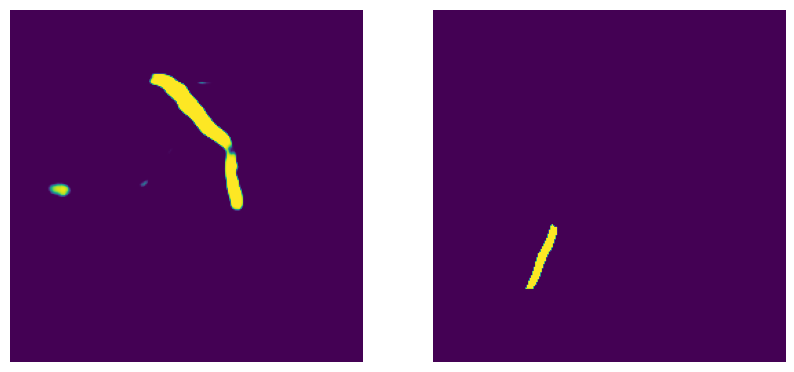

Average Dice Similarity Coefficient (DSC) at Epcoh 100 : 0.05920011709444225


Epoch [102/2], Average Loss: 0.09921907824277877


Epoch [103/2], Average Loss: 0.09878229516744613


Epoch [104/2], Average Loss: 0.0984723853468895


Epoch [105/2], Average Loss: 0.09821824753284454


Epoch [106/2], Average Loss: 0.09783860301971435
Epoch [106/2], validation Loss: 1.0923664999008178


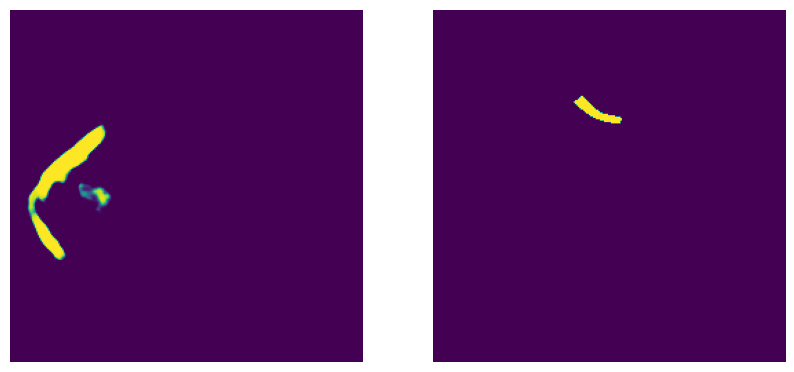

Average Dice Similarity Coefficient (DSC) at Epcoh 105 : 0.12741724150255324


Epoch [107/2], Average Loss: 0.0973897577226162


Epoch [108/2], Average Loss: 0.09695190051198006


Epoch [109/2], Average Loss: 0.09658307898044587


Epoch [110/2], Average Loss: 0.09628486293554306


Epoch [111/2], Average Loss: 0.09599895933270454
Epoch [111/2], validation Loss: 1.0708030259609223


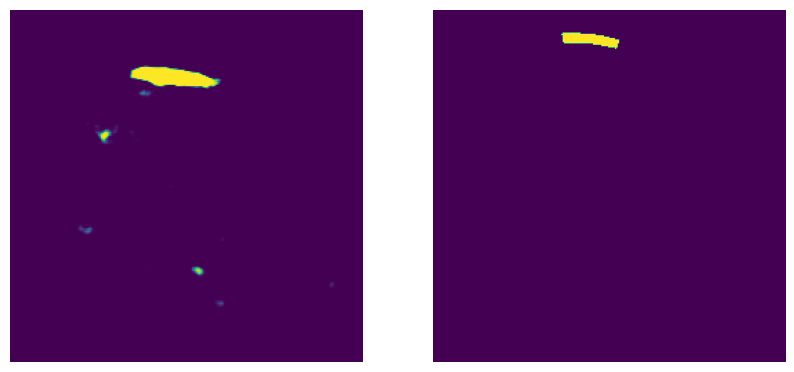

Average Dice Similarity Coefficient (DSC) at Epcoh 110 : 0.1832984239421785


Epoch [112/2], Average Loss: 0.09573606407642364


Epoch [113/2], Average Loss: 0.09563165667653084


Epoch [114/2], Average Loss: 0.09533810564875603


Epoch [115/2], Average Loss: 0.09511167746782302


Epoch [116/2], Average Loss: 0.09487598878145218
Epoch [116/2], validation Loss: 1.0536789226531982


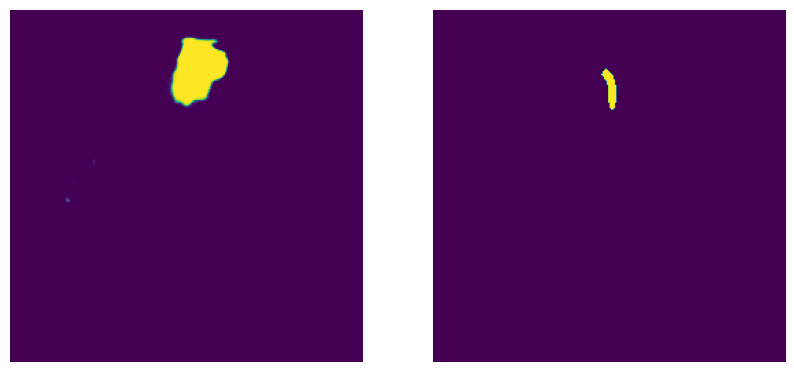

Average Dice Similarity Coefficient (DSC) at Epcoh 115 : 0.20691229168325662


Epoch [117/2], Average Loss: 0.09464196860790253


Epoch [118/2], Average Loss: 0.09448608368635178


Epoch [119/2], Average Loss: 0.09439831218123436


Epoch [120/2], Average Loss: 0.09427935737371444


Epoch [121/2], Average Loss: 0.09398821124434471
Epoch [121/2], validation Loss: 1.0388380002975464


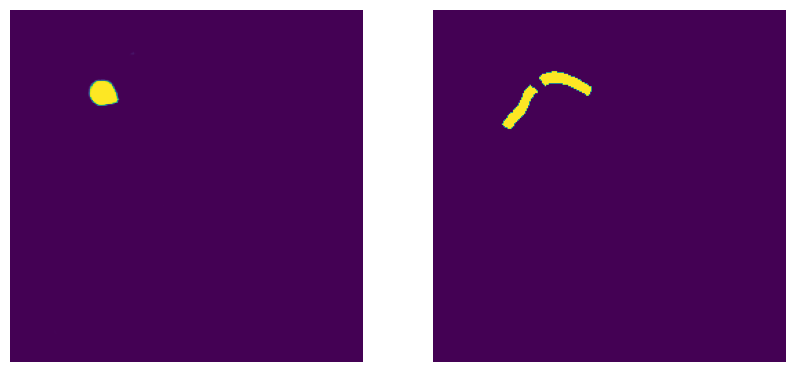

Average Dice Similarity Coefficient (DSC) at Epcoh 120 : 0.25539702229201794


Epoch [122/2], Average Loss: 0.09382770782709121


Epoch [123/2], Average Loss: 0.09371247452497482


Epoch [124/2], Average Loss: 0.09365233504772186


Epoch [125/2], Average Loss: 0.09353215768933296


Epoch [126/2], Average Loss: 0.09341744861006737
Epoch [126/2], validation Loss: 1.0251562464237214


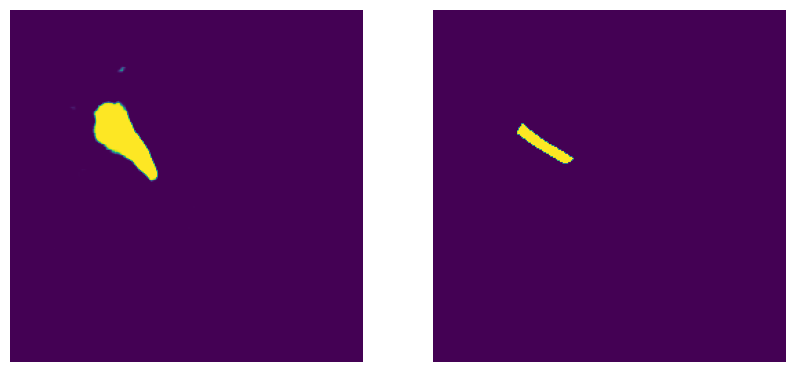

Average Dice Similarity Coefficient (DSC) at Epcoh 125 : 0.2835060141980648


Epoch [127/2], Average Loss: 0.09330020743608475


Epoch [128/2], Average Loss: 0.09315081515908241


Epoch [129/2], Average Loss: 0.09304996582865716


Epoch [130/2], Average Loss: 0.0929302310347557


Epoch [131/2], Average Loss: 0.09286439973115922
Epoch [131/2], validation Loss: 1.0102297616004945


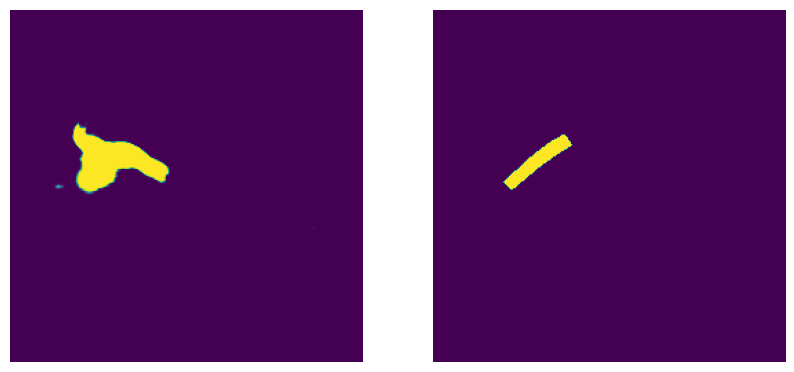

Average Dice Similarity Coefficient (DSC) at Epcoh 130 : 0.32216579884290697


KeyboardInterrupt: 

In [45]:
NUM_EPOCHS = 100

from tqdm import tqdm, trange

model = model.to("cuda")

for epoch in range(100, NUM_EPOCHS+100):
    loss_list = []
    model.train()  # Set model to training mode
    total_loss = 0.0
    
    # Use tqdm for progress bar
    for step, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)):
        img, msk = batch
        img = img.to("cuda")
        msk = msk.to("cuda")
        
        optimizer.zero_grad()
        
        out = model(img)

        loss_val = loss(out, msk) * 0.1

        loss_val.backward()
        optimizer.step()

        total_loss += loss_val.item()
        
    avg_loss = total_loss / len(final_dataloader)
    
    # Print average loss for the epoch
    print(f"Epoch [{epoch + 1}/{2}], Average Loss: {avg_loss}")
    loss_list.append({epoch : avg_loss})
    
    if epoch % 5 == 0:
        with torch.no_grad():
            val_loss = validate(model, val_loader = val_dataloader, criterion = loss)
        print(f"Epoch [{epoch + 1}/{2}], validation Loss: {val_loss}")
        
    
        with torch.no_grad():
            img, msk = next(iter(test_dataloader))
            img = img.to("cuda")
            msk = msk.to("cuda")

            out = model(img)
        
        draw_image(out[0], msk[0])
        
        avg_dice = []
        model.eval()  # Set model to evaluation mode

        with torch.no_grad():  # Disable gradient computation
            for img, msk in val_dataloader:
                img = img.to("cuda")
                msk = msk.to("cuda")

                out = model(img)

                out = (out > 0.5).type(torch.int32)
                msk = (msk > 0.5).type(torch.int32)

                # Compute Dice similarity coefficient (DSC)
                intersection = torch.sum(out * msk)
                union = torch.sum(out) + torch.sum(msk)
                dsc = (2.0 * intersection) / (union + 1e-8)  # Add small epsilon to avoid division by zero

                avg_dice.append(dsc.item())

        # Calculate the average DSC
        average_dice = sum(avg_dice) / len(avg_dice)

        print(f"Average Dice Similarity Coefficient (DSC) at Epcoh {epoch} :", average_dice)

In [46]:
torch.save(model.state_dict(), "../experiments/model_pytorch_final_val_32.pt")
torch.save(optimizer.state_dict(), "../experiments/optimizer_adam.opt")

In [12]:
model.load_state_dict(torch.load("../experiments/model_pytorch_final_val_32.pt"))

<All keys matched successfully>

In [22]:
from torcheval.metrics.functional import binary_precision, binary_recall

In [31]:
avg_dice = []
avg_prec = []
avg_rec  = []

model.eval()  # Set model to evaluation mode
model.to("cuda")

with torch.no_grad():  # Disable gradient computation
    for img, msk in train_dataloader:
        img = img.to("cuda")
        msk = msk.to("cuda")

        out = model(img)

        out = (out > 0.5).type(torch.int32)
        msk = (msk > 0.5).type(torch.int32)

        # Compute Dice similarity coefficient (DSC)
        intersection = torch.sum(out * msk)
        union = torch.sum(out) + torch.sum(msk)
        dsc = (2.0 * intersection) / (union + 1e-8)  # Add small epsilon to avoid division by zero
        
        TP = torch.sum((out == 1) & (msk == 1)).item()
        FP = torch.sum((out == 1) & (msk == 0)).item()
        TN = torch.sum((out == 0) & (msk == 0)).item()
        FN = torch.sum((out == 0) & (msk == 1)).item()

        pre = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        avg_dice.append(dsc.item())
        avg_prec.append(prec)
        avg_rec.append(rec)

# Calculate the average DSC
average_dice = sum(avg_dice) / len(avg_dice)
average_prec = sum(avg_prec) / len(avg_prec)
average_rec  = sum(avg_rec)  / len(avg_rec)

print("Average Dice Similarity Coefficient (DSC):", average_dice)
print("Average Precision :", average_prec)
print("Average Recall :", average_rec)

Average Dice Similarity Coefficient (DSC): 0.5668393030166626
Average Precision : tensor(0.7234, device='cuda:0')
Average Recall : 0.9354496694741732


In [30]:
avg_dice = []
avg_prec = []
avg_rec  = []

model.eval()  # Set model to evaluation mode
model.to("cuda")

with torch.no_grad():  # Disable gradient computation
    for img, msk in test_dataloader:
        img = img.to("cuda")
        msk = msk.to("cuda")

        out = model(img)

        out = (out > 0.5).type(torch.int32)
        msk = (msk > 0.5).type(torch.int32)

        # Compute Dice similarity coefficient (DSC)
        intersection = torch.sum(out * msk)
        union = torch.sum(out) + torch.sum(msk)
        dsc = (2.0 * intersection) / (union + 1e-8)  # Add small epsilon to avoid division by zero
        
        TP = torch.sum((out == 1) & (msk == 1)).item()
        FP = torch.sum((out == 1) & (msk == 0)).item()
        TN = torch.sum((out == 0) & (msk == 0)).item()
        FN = torch.sum((out == 0) & (msk == 1)).item()

        pre = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        avg_dice.append(dsc.item())
        avg_prec.append(prec)
        avg_rec.append(rec)

# Calculate the average DSC
average_dice = sum(avg_dice) / len(avg_dice)
average_prec = sum(avg_prec) / len(avg_prec)
average_rec  = sum(avg_rec)  / len(avg_rec)

print("Average Dice Similarity Coefficient (DSC) for Test:", average_dice)
print("Average Precision For Test:", average_prec)
print("Average Recall For Test:", average_rec)

Average Dice Similarity Coefficient (DSC) for Test: 0.4108345599969228
Average Precision For Test: tensor(0.7234, device='cuda:0')
Average Recall For Test: 0.8160060989410473


In [28]:
avg_dice = []
avg_prec = []
avg_rec  = []

model.eval()  # Set model to evaluation mode
model.to("cuda")

with torch.no_grad():  # Disable gradient computation
    for img, msk in val_dataloader:
        img = img.to("cuda")
        msk = msk.to("cuda")

        out = model(img)

        out = (out > 0.5).type(torch.int32)
        msk = (msk > 0.5).type(torch.int32)

        # Compute Dice similarity coefficient (DSC)
        intersection = torch.sum(out * msk)
        union = torch.sum(out) + torch.sum(msk)
        dsc = (2.0 * intersection) / (union + 1e-8)  # Add small epsilon to avoid division by zero
        
        TP = torch.sum((out == 1) & (msk == 1)).item()
        FP = torch.sum((out == 1) & (msk == 0)).item()
        TN = torch.sum((out == 0) & (msk == 0)).item()
        FN = torch.sum((out == 0) & (msk == 1)).item()

        pre = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        avg_dice.append(dsc.item())
        avg_prec.append(prec)
        avg_rec.append(rec)

# Calculate the average DSC
average_dice = sum(avg_dice) / len(avg_dice)
average_prec = sum(avg_prec) / len(avg_prec)
average_rec  = sum(avg_rec)  / len(avg_rec)

print("Average Dice Similarity Coefficient (DSC) for Validation:", average_dice)
print("Average Precision For Validation :", average_prec)
print("Average Recall For Validation:", average_rec)

Average Dice Similarity Coefficient (DSC) for Validation: 0.3123780551552773
Average Precision For Validation : tensor(0.7234, device='cuda:0')
Average Recall For Validation: 0.5499009248226074
